In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import dtnnlib as dtnn

In [3]:
from nflib.flows import SequentialFlow, NormalizingFlow, ActNorm
import nflib.res_flow as irf
import nflib.coupling_flows as cflow
import nflib

In [4]:
def twospirals(n_points, noise=.5, angle=784):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * angle * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))), 
            np.hstack((np.zeros(n_points),np.ones(n_points))))

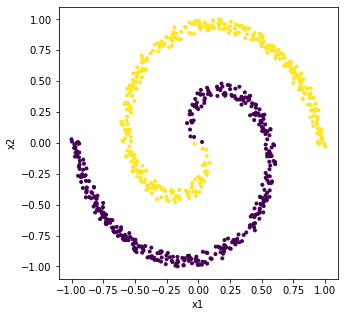

In [5]:
x, y = twospirals(400, angle=360)
x, y = x/x.max(axis=0, keepdims=True), y.reshape(-1)
xx, yy = torch.FloatTensor(x), torch.FloatTensor(y.reshape(-1,1))

x1 = xx[:,0]
x2 = xx[:,1]

%matplotlib inline
plt.figure(figsize=(5,5))
plt.scatter(x1, x2, c=y, marker='.')
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

In [6]:
len(xx)

800

In [7]:
class DistanceRegressor(nn.Module):
    def __init__(self, input_dim, inv_temp=1):
        super().__init__()
        self.centers = nn.Parameter(torch.rand(1, input_dim)*2-1)
        self.bias = nn.Parameter(torch.ones(1)*-0.5)
        self.inv_temp = nn.Parameter(torch.ones(1)*inv_temp)

        
    def forward(self, x):
        x = torch.norm(x-self.centers, dim=-1, keepdim=True)
        x = torch.nn.functional.softplus(x-0.1, beta=5)
#         x = -x*self.inv_temp + self.bias
        x = x*self.inv_temp + self.bias
        return x

In [8]:
# device = torch.device("cuda:0")
device = torch.device("cpu")

In [9]:
# yy = yy.reshape(-1).type(torch.long)
xx, yy = xx.to(device), yy.to(device)

## Prototype Reducers

In [10]:
# class Reducer_LearnableQuant(nn.Module):
#     def __init__(self, input_dim, num_samples):
#         self.samples = nn.Parameter(torch.randn(num_samples, input_dim))
        
#     def initialize_samples_with_data(self, samples):
#         N = self.samples.shape[0]
#         self.samples.data = samples.to(self.samples.device)[:N]
#         pass
        
#     def forward(self, x):
#         dist = torch.cdist(x, self.samples)

In [11]:
# https://github.com/MishaLaskin/vqvae/blob/master/models/quantizer.py

class VectorQuantizer(nn.Module):
    """
    Discretization bottleneck part of the VQ-VAE.

    Inputs:
    - n_e : number of embeddings
    - e_dim : dimension of embedding
    - beta : commitment cost used in loss term, beta * ||z_e(x)-sg[e]||^2
    """

    def __init__(self, num_embedding, embedding_dim, beta):
        super(VectorQuantizer, self).__init__()
        self.n_e = num_embedding
        self.e_dim = embedding_dim
        self.beta = beta

        self.embedding = nn.Embedding(self.n_e, self.e_dim)
        self.embedding.weight.data.uniform_(-1.0 / self.n_e, 1.0 / self.n_e)
        
    def initialize_embedding_with_data(self, data):
        N = self.embedding.weight.shape[0]
        assert self.embedding.weight.shape[1] == data.shape[1]
        self.embedding.weight.data = data.to(self.embedding.weight.device)[:N]
        pass

    def forward(self, z, embedding=None):
        """
        Inputs the output of the encoder network z and maps it to a discrete 
        one-hot vector that is the index of the closest embedding vector e_j

        z (continuous) -> z_q (discrete)

        """
        # distances from z to embeddings e_j (z - e)^2 = z^2 + e^2 - 2 e * z

#         z_flattened = z.view(-1, self.e_dim)
#         d = torch.sum(z_flattened ** 2, dim=1, keepdim=True) + \
#             torch.sum(self.embedding.weight**2, dim=1) - 2 * \
#             torch.matmul(z_flattened, self.embedding.weight.t())
        if embedding is None:
            embedding = self.embedding.weight
        
        d = torch.cdist(z, embedding)
        
        # find closest encodings
        min_encoding_indices = torch.argmin(d, dim=1).unsqueeze(1)
        min_encodings = torch.zeros(
            min_encoding_indices.shape[0], self.n_e).to(device)
        min_encodings.scatter_(1, min_encoding_indices, 1)
        

        # get quantized latent vectors
        z_q = torch.matmul(min_encodings, embedding).view(z.shape)

        # compute loss for embedding
        loss = torch.mean((z_q.detach()-z)**2) + self.beta * \
            torch.mean((z_q - z.detach()) ** 2)

        # preserve gradients
        z_q = z + (z_q - z).detach()

        # perplexity
        e_mean = torch.mean(min_encodings, dim=0)
        perplexity = torch.exp(-torch.sum(e_mean * torch.log(e_mean + 1e-10)))

        return z_q, loss, perplexity #min_encodings, min_encoding_indices

In [32]:
vq = VectorQuantizer(10, 2, beta=0.25)
vq(torch.randn(3, 2))

(tensor([[ 0.0881,  0.0522],
         [-0.0628, -0.0611],
         [ 0.0704,  0.0959]]),
 tensor(0.8438, grad_fn=<AddBackward0>),
 tensor(3.))

In [33]:
gen = cflow.MLP_Generator([10])
# flows = [cflow.AffineHalfFlow(2, i%2, gen) for i in range(6)]

# flows = [ActNorm(2)]
# for i in range(4):
#     flows += [cflow.AffineHalfFlow(2, i%2, gen)]
#     if i%2 == 1:
#         flows += [ActNorm(2)]
# revnet = SequentialFlow(flows)

revnet = SequentialFlow([ActNorm(2)])

revnet

SequentialFlow(
  (flows): ModuleList(
    (0): ActNorm()
  )
)

In [34]:
yout = revnet.forward(xx)

In [35]:
xrec = revnet.inverse(yout)
torch.allclose(xx, xrec)

True

In [36]:
z = revnet.forward(xx)
# vq.embedding.weight.data.clamp_(-1, 1)
zq, qloss, perplexity= vq(z)
xq = revnet.inverse(zq)

In [37]:
### different type of quantization
z = revnet.forward(xx)
zq, qloss, perplexity= vq(z)
zq = 0.5*z+0.5*zq
xq = revnet.inverse(zq)

In [38]:
recon_loss = torch.mean((xq - xx)**2) #/ x_train_var
loss = recon_loss + qloss
loss

tensor(1.1674, grad_fn=<AddBackward0>)

## Create Model

In [39]:
# list(revnet.parameters())
# list(vq.parameters())

In [40]:
optimizer = torch.optim.Adam(list(revnet.parameters())+list(vq.parameters()), lr=0.01)
# criterion = nn.BCELoss()

Epoch: 99, loss:0.0422, rec_loss:0.0309, qloss:0.0422, perplexity:9.4946
Epoch: 199, loss:0.0283, rec_loss:0.0244, qloss:0.0283, perplexity:9.8059
Epoch: 299, loss:0.0238, rec_loss:0.0238, qloss:0.0238, perplexity:9.8208
Epoch: 399, loss:0.0203, rec_loss:0.0235, qloss:0.0203, perplexity:9.8418
Epoch: 499, loss:0.0173, rec_loss:0.0234, qloss:0.0173, perplexity:9.8418
Epoch: 599, loss:0.0148, rec_loss:0.0233, qloss:0.0148, perplexity:9.8636
Epoch: 699, loss:0.0126, rec_loss:0.0231, qloss:0.0126, perplexity:9.8962
Epoch: 799, loss:0.0108, rec_loss:0.0230, qloss:0.0108, perplexity:9.8875
Epoch: 899, loss:0.0094, rec_loss:0.0229, qloss:0.0094, perplexity:9.8875
Epoch: 999, loss:0.0082, rec_loss:0.0229, qloss:0.0082, perplexity:9.8875


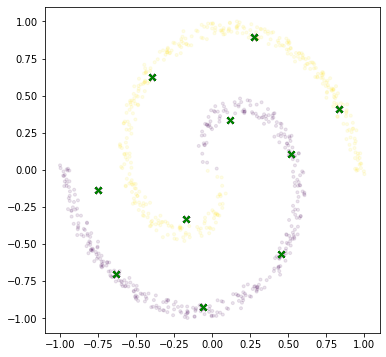

Epoch: 1099, loss:0.0072, rec_loss:0.0229, qloss:0.0072, perplexity:9.8875
Epoch: 1199, loss:0.0064, rec_loss:0.0229, qloss:0.0064, perplexity:9.8875
Epoch: 1299, loss:0.0056, rec_loss:0.0229, qloss:0.0056, perplexity:9.8875
Epoch: 1399, loss:0.0050, rec_loss:0.0229, qloss:0.0050, perplexity:9.8875
Epoch: 1499, loss:0.0045, rec_loss:0.0229, qloss:0.0045, perplexity:9.8875
Epoch: 1599, loss:0.0041, rec_loss:0.0229, qloss:0.0041, perplexity:9.8875
Epoch: 1699, loss:0.0037, rec_loss:0.0229, qloss:0.0037, perplexity:9.8875
Epoch: 1799, loss:0.0033, rec_loss:0.0228, qloss:0.0033, perplexity:9.8958
Epoch: 1899, loss:0.0030, rec_loss:0.0228, qloss:0.0030, perplexity:9.8958
Epoch: 1999, loss:0.0027, rec_loss:0.0228, qloss:0.0027, perplexity:9.8958


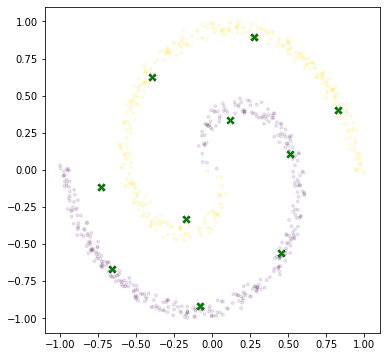

Epoch: 2099, loss:0.0025, rec_loss:0.0228, qloss:0.0025, perplexity:9.8958
Epoch: 2199, loss:0.0023, rec_loss:0.0228, qloss:0.0023, perplexity:9.8880
Epoch: 2299, loss:0.0021, rec_loss:0.0228, qloss:0.0021, perplexity:9.8880
Epoch: 2399, loss:0.0019, rec_loss:0.0228, qloss:0.0019, perplexity:9.8880
Epoch: 2499, loss:0.0017, rec_loss:0.0219, qloss:0.0017, perplexity:9.9772
Epoch: 2599, loss:0.0016, rec_loss:0.0215, qloss:0.0016, perplexity:9.9586
Epoch: 2699, loss:0.0015, rec_loss:0.0215, qloss:0.0015, perplexity:9.9586
Epoch: 2799, loss:0.0014, rec_loss:0.0215, qloss:0.0014, perplexity:9.9598
Epoch: 2899, loss:0.0013, rec_loss:0.0215, qloss:0.0013, perplexity:9.9568
Epoch: 2999, loss:0.0012, rec_loss:0.0215, qloss:0.0012, perplexity:9.9598


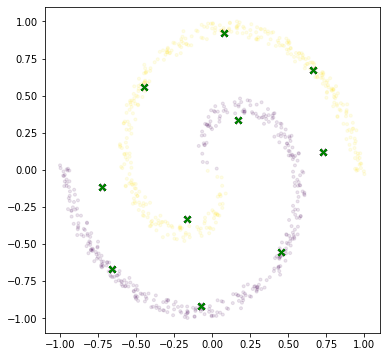

Epoch: 3099, loss:0.0011, rec_loss:0.0215, qloss:0.0011, perplexity:9.9598
Epoch: 3199, loss:0.0010, rec_loss:0.0215, qloss:0.0010, perplexity:9.9568
Epoch: 3299, loss:0.0010, rec_loss:0.0215, qloss:0.0010, perplexity:9.9568
Epoch: 3399, loss:0.0009, rec_loss:0.0215, qloss:0.0009, perplexity:9.9573
Epoch: 3499, loss:0.0008, rec_loss:0.0215, qloss:0.0008, perplexity:9.9541
Epoch: 3599, loss:0.0008, rec_loss:0.0215, qloss:0.0008, perplexity:9.9541
Epoch: 3699, loss:0.0007, rec_loss:0.0215, qloss:0.0007, perplexity:9.9544
Epoch: 3799, loss:0.0007, rec_loss:0.0215, qloss:0.0007, perplexity:9.9544
Epoch: 3899, loss:0.0007, rec_loss:0.0215, qloss:0.0007, perplexity:9.9541
Epoch: 3999, loss:0.0006, rec_loss:0.0215, qloss:0.0006, perplexity:9.9550


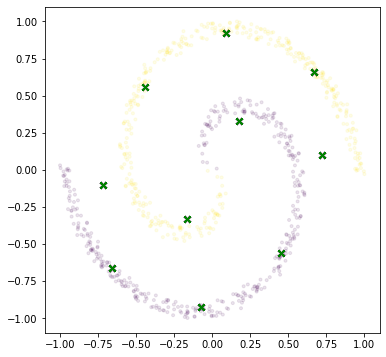

Epoch: 4099, loss:0.0006, rec_loss:0.0215, qloss:0.0006, perplexity:9.9544
Epoch: 4199, loss:0.0005, rec_loss:0.0215, qloss:0.0005, perplexity:9.9544
Epoch: 4299, loss:0.0005, rec_loss:0.0215, qloss:0.0005, perplexity:9.9550
Epoch: 4399, loss:0.0005, rec_loss:0.0215, qloss:0.0005, perplexity:9.9544
Epoch: 4499, loss:0.0005, rec_loss:0.0215, qloss:0.0005, perplexity:9.9544
Epoch: 4599, loss:0.0004, rec_loss:0.0215, qloss:0.0004, perplexity:9.9544
Epoch: 4699, loss:0.0004, rec_loss:0.0215, qloss:0.0004, perplexity:9.9535
Epoch: 4799, loss:0.0004, rec_loss:0.0216, qloss:0.0004, perplexity:9.9559
Epoch: 4899, loss:0.0004, rec_loss:0.0216, qloss:0.0004, perplexity:9.9580
Epoch: 4999, loss:0.0003, rec_loss:0.0215, qloss:0.0003, perplexity:9.9550


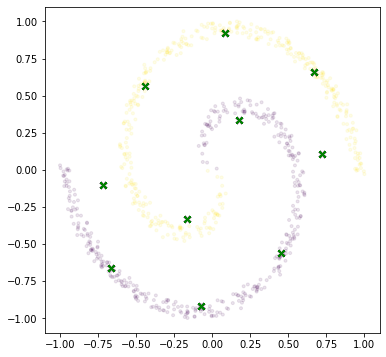

In [41]:
for epoch in range(5000):
    z = revnet.forward(xx)
    zq, qloss, perplexity= vq(z)
#     zq = 0.5*z+0.5*zq ## comment to remove this feature
    xq = revnet.inverse(zq)
    recon_loss = torch.mean((xq - xx)**2) #/ x_train_var
#     loss = recon_loss + qloss # + perplexity-> is not trainable
    loss = qloss
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1)%100 == 0:
        print(f'Epoch: {epoch}, loss:{float(loss):.4f}, rec_loss:{float(recon_loss):.4f}, qloss:{float(qloss):.4f}, perplexity:{float(perplexity):.4f}')

    if (epoch+1)%1000 == 0:
        ax = plt.figure(figsize=(6,6)).add_subplot()
        ax.scatter(x1, x2, c=y, marker= '.', alpha=0.1)
        ## plot centroids
        c = xq.data.numpy()
        ax.scatter(c[:,0], c[:,1], c='g', marker= 'x')
        plt.show()

In [ ]:
print(f'Epoch: {epoch}, loss:{float(loss):.4f}, rec_loss:{float(recon_loss):.4f}, qloss:{float(qloss):.4f}, perplexity:{float(perplexity):.4f}')

In [ ]:
ax = plt.figure(figsize=(6,6)).add_subplot()
z = revnet.forward(xx)
zq, qloss, perplexity= vq(z)
xq = revnet.inverse(zq)

ax.scatter(x1, x2, c=y, marker= '.', alpha=0.1)
c = xq.data.numpy()
ax.scatter(c[:,0], c[:,1], c='g', marker= 'x')
plt.show()

In [ ]:
list(revnet.parameters())[0].grad

In [ ]:
asdasd

## Send embeddings through the inversenet

In [ ]:
vq = VectorQuantizer(10, 2, beta=0.25)
a = torch.randn(3, 2)
vq(a)

In [ ]:
vq.embedding

In [ ]:
vq(a, torch.randn(10, 2)) ## produces different result, works !

In [ ]:
gen = cflow.MLP_Generator([10])
flows = [ActNorm(2)]
for i in range(4):
    flows += [cflow.AffineHalfFlow(2, i%2, gen)]
    if i%2 == 1:
        flows += [ActNorm(2)]
revnet = SequentialFlow(flows)

# revnet = SequentialFlow([ActNorm(2)])

revnet

In [ ]:
embedding = nn.Embedding(vq.n_e, vq.e_dim)
embedding.weight.data.uniform_(-1.0 / vq.n_e, 1.0 / vq.n_e)
embedding.weight

In [ ]:
z = revnet.forward(xx)
# vq.embedding.weight.data.clamp_(-1, 1)
zemb = revnet.forward(embedding.weight)
zq, qloss, perplexity= vq(z, zemb)
xq = revnet.inverse(zq)

In [ ]:
# ### different type of quantization
# z = revnet.forward(xx)
# zq, qloss, perplexity= vq(z)
# zq = 0.5*z+0.5*zq
# xq = revnet.inverse(zq)

In [ ]:
recon_loss = torch.mean((xq - xx)**2) #/ x_train_var
loss = recon_loss + qloss
loss

## Create Model

In [ ]:
# list(revnet.parameters())
# list(vq.parameters())

In [ ]:
optimizer = torch.optim.Adam(list(revnet.parameters())+list(vq.parameters())+list(embedding.parameters()), lr=0.01)
# criterion = nn.BCELoss()

In [ ]:
for epoch in range(5000):
    z = revnet.forward(xx)
    zemb = revnet.forward(embedding.weight)
    zq, qloss, perplexity= vq(z, zemb)
    zq = 0.5*z+0.5*zq ## comment to remove this feature
    xq = revnet.inverse(zq)
    recon_loss = torch.mean((xq - xx)**2) #/ x_train_var
    loss = recon_loss + qloss # + perplexity-> is not trainable
#     loss = qloss
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1)%100 == 0:
        print(f'Epoch: {epoch}, loss:{float(loss):.4f}, rec_loss:{float(recon_loss):.4f}, qloss:{float(qloss):.4f}, perplexity:{float(perplexity):.4f}')

    if (epoch+1)%1000 == 0:
        ax = plt.figure(figsize=(6,6)).add_subplot()
        ax.scatter(x1, x2, c=y, marker= '.', alpha=0.1)
        ## plot centroids
        c = xq.data.numpy()
        ax.scatter(c[:,0], c[:,1], c='g', marker= 'x')
        plt.show()

In [ ]:
print(f'Epoch: {epoch}, loss:{float(loss):.4f}, rec_loss:{float(recon_loss):.4f}, qloss:{float(qloss):.4f}, perplexity:{float(perplexity):.4f}')